<h2> 1) Setup <h2>

<h4> 1.1) Install Dependencies <h4>

In [1]:
#pip install opencv-python matplotlib
#!pip install tensorflow

<h4> 1.2) Import Dependencies <h4>

In [2]:
#Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

<h4>1.3) Set GPU Growth <h4>

In [4]:
#Avoid Out of memory errors by setting the GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h4> 1.4) Create Folder Structures <h4>

In [6]:
#Setting up folder paths for data
POS_PATH = os.path.join('data' , 'positive')
NEG_PATH = os.path.join('data' , 'negative')
ANC_PATH = os.path.join('data' , 'anchor')

In [7]:
#Make the Directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

<h2> 2) Collect Positives and Anchors <h2>

<h4>2.1) Untar Labelled Faces in the wild dataset <h4>

In [8]:
#http://vis-www.cs.umass.edu/lfw/
#Uncompressing Tar GZ labelled faces data in the wild dataset obtained from above link
#!tar -xf lfw.tgz

In [9]:
#Move lfw images to the following repository : data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

<h4>2.2) Collect Positive and Anchor classes <h4>

In [10]:
#Import UUID library to generate unique image names
import uuid

In [11]:
#Capture image using webcam for above data classes

#Establishing a connection to the webcam
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     #frame is the actual image
#     ret, frame = cap.read()
    
#     #Slicing frame to 250x250px
#     frame = frame[120:120+250, 200:200+250, :]
    
#     #Collect Anchors
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         #Create unique image with name
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         #Saving the anchor image
#         cv2.imwrite(imgname, frame)
        
    
#     #Collect Positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         #Create unique image with name
#         imgname2 = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         #Saving the positive image
#         cv2.imwrite(imgname2, frame)
    
    
#     #Show image back to screena
#     cv2.imshow('Image Collection', frame)
    
#     #Stopping or breaking from this loop when pressed key q
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
        
# #Release the webcam
# cap.release()
# #Close the image show frame
# cv2.destroyAllWindows()

In [12]:
#plt.imshow(frame[100:100+250, 250:250+250, :])

<h2> 3) Load and Preprocess Images <h2>

<h4>3.1) Get Image Directories <h4>

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
#dir_test.next()

<h4>3.2) Preprocessing - Scale and Resize <h4>

In [16]:
def preprocess(file_path):
    #Read an image from the file path
    byte_img = tf.io.read_file(file_path)
    #Load in the image
    img = tf.io.decode_jpeg(byte_img)

    #Resize the image into 100x100px(with 3 channels)
    img = tf.image.resize(img, (100,100))
    #Scale image to be between 0 and 1
    img = img/255.0

    return img

In [17]:
img = preprocess('data\\anchor\\7d31709b-9b14-11ec-8bf5-54ab3af688b8.jpg')

In [18]:
#img.numpy().max()

In [19]:
#plt.imshow(img)

In [20]:
#dataset.map(preprocess)

<h4>3.3) Create Labelled Dataset <h4>

In [21]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [22]:
#We match the anchors and positives to be ones and anchors and negatives to be zeros
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
samples = data.as_numpy_iterator()

In [24]:
example = samples.next()

In [25]:
example

(b'data\\anchor\\7b3a3bdd-9b14-11ec-9cd8-54ab3af688b8.jpg',
 b'data\\positive\\ba2ee3b4-9b14-11ec-b154-54ab3af688b8.jpg',
 1.0)

<h4>3.4) Build Train and Test Partition <h4>

In [26]:
def preprocess_twin(input_img,validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
#We use the * to unpack the data in the example variable into input_img and validation_img and Label
res = preprocess_twin(*example)

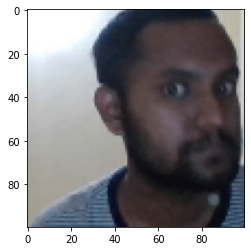

In [28]:
plt.imshow(res[1])

In [29]:
#This is the label for the above example 
res[2]

1.0

In [30]:
#Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
#Shuffling images to get positive and negative images mixed in the sample
data = data.shuffle(buffer_size=1024)

1.0

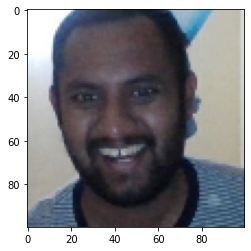

In [31]:
samples = data.as_numpy_iterator()
samp = samples.next()

plt.imshow(samp[1])

#Give the label for the above sample data
samp[2]

### Training partition

In [32]:
#Training partition

#Take a certain percentage of the data(70% in this case)
train_data = data.take(round(len(data)*.7))
#Make batches of 16
train_data = train_data.batch(16)
#Amount of next batches to start preprocessing to avoid bottleneck in neural network
train_data = train_data.prefetch(8)

In [33]:
train_samples = train_data.as_numpy_iterator()

In [34]:
len(train_samples.next()[0])

16

### Testing partition

In [35]:
#Testing partition

#Skip the 70% training sample
test_data = data.skip(round(len(data)*.7))
#Get the remaining 30% for testing
test_data = test_data.take(round(len(data)*.3))

test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

<h2> 4) Model Engineering <h2>

<h4>4.1) Build Embedding layer <h4>

In [36]:
#Input layer
inp = Input(shape=(100,100,3), name='input_image')

In [37]:
#Convolutional Layer
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [38]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

## Example of max pooling
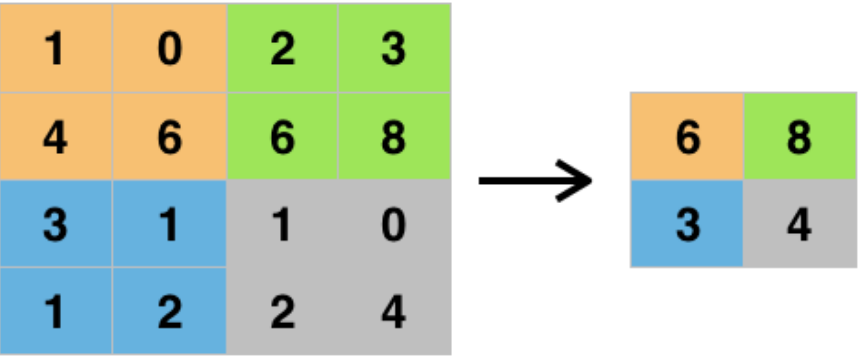

In [39]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    #First Block of the Convolutional Architecture
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    #Second Block of the Convolutional Architecture
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #Third Block of the Convolutional Architecture
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #Final embedding Block of the Convolutional Architecture
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    #Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
    f1 = Flatten()(c4)
    #Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [40]:
embedding = make_embedding()

In [41]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 128)       26

<h4>4.2) Build Distance Layer <h4>

In [42]:
#Siamese L1 distance class
class L1Dist(Layer):
    
    #Init method for inheritance from keras layers
    def __init__(self, **kwargs):
        super().__init__()
        
    #Function which tells what to do when input is passed
    #Similarity calculation is done
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [43]:
l1 = L1Dist()

<h4>4.3) Make Siamese Model <h4>

In [44]:
def make_siamese_model():
    
    # Handle inputs
    #Anchor image input for the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    #Validation image input for the network
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    #Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese_Network')

In [45]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0]

<h2> 5) Training <h2>

<h4>5.1) Setup Loss and Optimizer <h4>

In [46]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

#HINT => To get documentation we can do this - tf.losses.BinaryCrossentropy??

## Binary cross entropy compares each of the predicted probabilities to actual class output which can be either 0 or 1. It then calculates the score that penalizes the probabilities based on the distance from the expected value. That means how close or far from the actual value
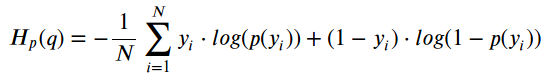

In [47]:
# Adam optimization is a stochastic gradient descent method 
#that is based on adaptive estimation of first-order and second-order moments.

opt = tf.keras.optimizers.Adam(1e-4)  #Learning rate of 10^-4(0.0001)

<h4>5.2) Establish Checkpoints <h4>

In [48]:
#Making checkpoints while training the model
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [49]:
#To reload from the chekcpoint we can use model.load('path_to_chekcpoint')

<h4>5.3) Build Train Step Function

#### tf. function is a decorator function provided by Tensorflow 2.0 that converts regular python code to a callable Tensorflow graph function, which is usually more performant and python independent. It is used to create portable Tensorflow models

In [50]:
@tf.function
def train_step(batch):
    
    #tf.gradientTape is used to record operations for automatic differentiation. This is used to get the gradients of our NN
    with tf.GradientTape() as tape:
        #Get anchor and positive/negative image
        X = batch[:2]
        #Get label
        y = batch[2]
        
        #Forward pass
        yhat = siamese_model(X, training=True)
        #Calculate loss
        loss = binary_cross_loss(y, yhat)
        
    #Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    #Return loss
    return loss
        

<h4>5.4) Build Training Loop <h4>

In [51]:
def train(data, EPOCHS):
    #Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        #Loop through each batch
        for idx, batch in enumerate(data):
            #Run train step here
            train_step(batch)
            progbar.update(idx+1)
            
        #Save checkpoints for every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        

<h4>5.5) Train the model <h4>

In [52]:
EPOCHS = 50

In [53]:
#train(train_data, EPOCHS)

<h2> 6) Evaluate Model <h2>

<h4>6.1) Import metrics and make Predictions <h4>

In [54]:
# Import Metric calculations
from tensorflow.keras.metrics import Precision, Recall

#### Precision demonstrates what proportion of +ve identifications were actually correct
#### Recall shows what proportion of actual +ves were identified correctly

In [55]:
#Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [56]:
# Make Predictions
y_hat = siamese_model.predict([test_input, test_val])
#y_hat

In [57]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]
#Same as writing a for loop to iterate through y_hat and using and if statement to check whether >0.5 and mark it as 1
#if not mark as 0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [58]:
#Actual labels of the images
y_true

array([0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

<h4>6.2) Calculating metrics to check accuracy <h4>

In [59]:
#Creating a metric object
m1 = Precision()

#Calculating the recall value
m1.update_state(y_true, y_hat)

#Return recall result
m1.result().numpy()

0.0

In [60]:
#Creating a metric object
m2 = Recall()

#Calculating the recall value
m2.update_state(y_true, y_hat)

#Return recall result
m2.result().numpy()

0.0

<h4>6.3) Visualize results <h4>

#### Visualizing a positive result

<function matplotlib.pyplot.show(close=None, block=None)>

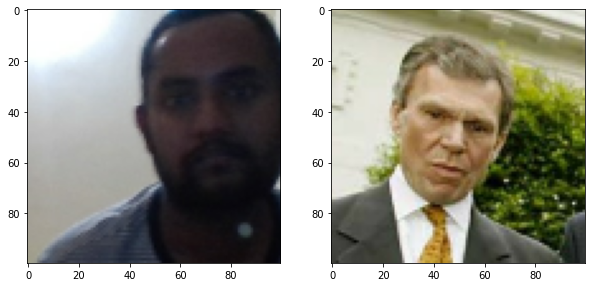

In [61]:
#Set plot size and using subplots to show both input_img and validation_img
plt.figure(figsize=(10,8))

#Left side input image plot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

#Right side validation image plot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

#Renders final plot
plt.show

#### Visualizing a negative result

<function matplotlib.pyplot.show(close=None, block=None)>

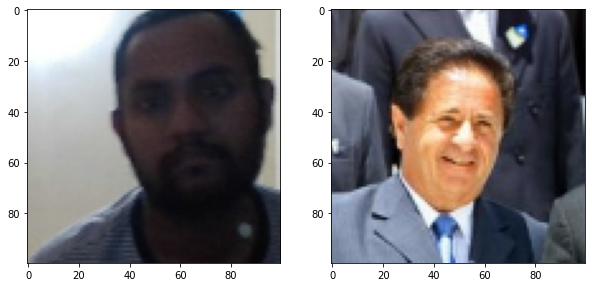

In [62]:
#Set plot size and using subplots to show both input_img and validation_img
plt.figure(figsize=(10,8))

#Left side input image plot
plt.subplot(1,2,1)
plt.imshow(test_input[13])

#Right side validation image plot
plt.subplot(1,2,2)
plt.imshow(test_val[13])

#Renders final plot
plt.show

<h2> 7) Save Model <h2>

In [63]:
#Save weights
#siamese_model.save('siamesemodel.h5')

In [73]:
# Reload the model
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [74]:
# Make predictions using reloaded model 
model.predict([test_input, test_val])

array([[5.00390744e-13],
       [1.34139158e-10],
       [1.00000000e+00],
       [9.99999046e-01],
       [9.99999881e-01],
       [9.99092579e-01],
       [9.99938846e-01],
       [9.99999762e-01],
       [1.21972725e-08],
       [2.35671127e-08],
       [9.99998808e-01],
       [1.00000000e+00],
       [9.91342366e-01],
       [8.15653046e-13],
       [1.00000000e+00],
       [4.85388452e-10]], dtype=float32)

In [75]:
# View reloaded model summary 
model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0]

<h2> 8) Real time Test <h2>

<h4> 8.1) Verification Function <h4>

In [67]:
#application_data/verification_images

In [80]:
def verify(model, detection_threshold, verification_threshold):
    #Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        #Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    
    return results, verified    
        
    #Detection threshold: Metric above which a prediction is considered positive
    #Verification threshold: Proportion of positive predictions / total positive samples

<h4>8.2) OpenCV Real Time Verification <h4>

In [69]:
# cap  = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()
#     frame = frame[120:120+250, 200:200+250, :]
    
#     cv2.imshow('verification', frame)
    
    
#     #Verification trigger
#     if cv2.waitKey(10) & 0xFF == ord('v'):
#         #Save inpu image to application_data/input_image folder
#         cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
#         #Run verification
#         results, verified = verify(model, 0.9, 0.7)
#         print(verified)
        
    
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [83]:
results, verified = verify(model, 0.9, 0.7)
verified

False